# Predicting Cardiovascular Disease

# Overview

Cardiovascular disease (CVD) is the leading global cause of death. Analyzing a dataset of 70,000 surveyed patients, we aimed to identify correlations and predictors of CVD. Through data cleaning and analysis, we discovered significant factors that influence the likelihood of having CVD. Specifically, we found that systolic and diastolic blood pressure, cholesterol, age, and weight were the largest indicators of susceptibility to CVD.

# Names

- Andrew Tan
- Arnav Taneja
- Matthew Kim
- Henry Liu

<a id='research_question'></a>
# Research Question

What (if any) effect do age, height, weight, gender, systolic blood pressure, diastolic blood pressure, cholesterol levels, glucose levels, smoking activity, alcoholism, and physical activity determine whether or not an individual gets CVD?  How well can we predict whether a person will have CVD given their age, height, weight, gender, systolic blood pressure, diastolic blood pressure, cholesterol levels, glucose levels, smoking activity, alcoholism, and physical activity? 

<a id='background'></a>

## Background & Prior Work

Cardiovascular disease is the leading global cause of death, resulting in over 19 million deaths in 2020 [2]. CVD is a multifactorial disease with several risk factors, such as age, gender, high blood pressure, and obesity. Therefore, it is essential to understand the interactions among these risk factors to develop effective prevention and treatment strategies. In particular, exploring how age, height, weight, gender, systolic blood pressure (SBP), and diastolic blood pressure (DBP) interact can help identify the risk of CVD.


Numerous studies have shown that age, gender, and blood pressure are significant predictors of CVD risk. For instance, a study conducted in Italy found a strong correlation between levels of SBP and the risk of coronary heart disease and cerebrovascular disease [3]. Additionally, a study conducted in the southern states of the US identified obesity, as measured by body mass index (BMI), as a significant risk factor for CVD [1].


While previous research has identified the importance of these risk factors, there is still much to learn about how these factors interact to predict CVD development. For example, the Framingham study has been investigating the predictive ability of various risk factors, including age, gender, BMI, and blood pressure, for CVD in Framingham, Massachusetts, since 1948. This study found that combining multiple risk factors enhances the predictive accuracy of CVD risk compared to using a single risk factor [4].


In summary, understanding the complex interactions among physiological factors that contribute to CVD risk is crucial for developing effective prevention and treatment strategies. Although age, gender, blood pressure, and obesity have been identified as critical risk factors, further research is needed to investigate how these factors interact and how well they can predict CVD risk.



References:
<br>[1] Akil, Luma, and H Anwar Ahmad. "Relationships between obesity and cardiovascular diseases in four southern states and Colorado." Journal of health care for the poor and underserved vol. 22,4 Suppl (2011)
<br>[2] American Heart Association. "Heart Disease and Stroke Statistics-2022 Update: A Report From the American Heart Association." Circulation, vol. 145, no. 8, 2022
<br>[3] Borghi, Claudio et al. "The relationship between systolic blood pressure and cardiovascular risk--results of the Brisighella Heart Study." Journal of clinical hypertension (Greenwich, Conn.) vol. 5,1 (2003)
<br>[4] D'Agostino, Ralph B Sr et al. "Cardiovascular Disease Risk Assessment: Insights from Framingham." Global heart vol. 8,1 (2013)

# Hypothesis


Our team has formulated hypotheses regarding the factors influencing the likelihood of cardiovascular disease. We propose that systolic and diastolic blood pressure play a pivotal role in determining disease presence. Additionally, we suspect that age, height, and weight are significant factors as they contribute to the calculation of obesity, a well-documented risk factor for cardiovascular disease as mentioned in the background and prior work section.

Based on our hypotheses, we aim to develop a robust predictive model that accurately predicts an individual's probability of having cardiovascular disease using their health data. While we acknowledge that predicting disease likelihood extends beyond the factors we are examining, we believe that our selected factors offer sufficient insight to achieve accurate predictions.

# Dataset(s)

- Dataset Name: Cardiovascular Disease Dataset
- Link to the dataset: https://www.kaggle.com/datasets/sulianova/cardiovascular-disease-dataset 
- Number of observations: 70,000

The Cardiovascular Disease Dataset contains values that were collected at the moment of medical examination from a random sample of 70,000 patients. Variables that were recorded include age, height, weight, gender, systolic blood pressure, cholesterol, glucose, smoking, alcohol intake, physical activity, and the presence or absence of CVD. Patients containing erroneous data, missing data values, heights, weights, and blood pressures that are significant outliers or impossible to measure will be removed.

# Setup

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import shap

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import metrics
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, ConfusionMatrixDisplay

/Users/henryliu/anaconda3/lib/python3.10/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/henryliu/anaconda3/lib/python3.10/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_

In [2]:
cardio = pd.read_csv('./cardio_train.csv', sep=';')
cardio.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Data Cleaning & Pre-Processing

In [3]:
def featureConversion(item):
    if item == 1:
        return 'normal'
    elif item == 2:
        return 'above normal'
    else:
        return 'well above normal'

# Converting data from days to years
cardio['age'] = cardio['age'] / 365
    
# Filtering out improbable data
cardio = cardio[((cardio['ap_hi'] > 0) & (cardio['ap_lo'] > 0))]
cardio = cardio[(cardio['age'] >= cardio['age'].quantile(0.05)) & (cardio['age'] <= cardio['age'].quantile(0.95)) &
                 (cardio['height'] >= cardio['height'].quantile(0.05)) & (cardio['height'] <= cardio['height'].quantile(0.95))]

cardio2 = cardio.copy()

# Converting variables from numbered categories to detailed categories
cardio['cholesterol'] = cardio['cholesterol'].apply(featureConversion)
cardio['gluc'] = cardio['gluc'].apply(featureConversion)
cardio['gender'] = cardio['gender'].apply(lambda x: 'woman' if x == 1 else 'man')
cardio['smoke'] = cardio['smoke'].apply(lambda x: 'non-smoker' if x == 0 else 'smoker')
cardio['alco'] = cardio['alco'].apply(lambda x: 'no alcohol' if x == 0 else 'alcohol')
cardio['active'] = cardio['active'].apply(lambda x: 'no exercise' if x == 0 else 'exercise')
cardio['cardio'] = cardio['cardio'].apply(lambda x: 'no CVD' if x == 0 else 'has CVD')
cardio2

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69994,99992,57.736986,1,165,80.0,150,80,1,1,0,0,1,1
69995,99993,52.712329,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,61.920548,1,158,126.0,140,90,2,2,0,0,1,1
69998,99998,61.454795,1,163,72.0,135,80,1,2,0,0,0,1


# Data Visualization

In [4]:
summary_stats = cardio.describe()
print(summary_stats)

                 id           age        height        weight         ap_hi  \
count  57678.000000  57678.000000  57678.000000  57678.000000  57678.000000   
mean   50004.913919     53.453483    164.465828     74.132368    128.863466   
std    28829.618656      5.850682      6.360731     13.913530    158.647620   
min        0.000000     41.287671    152.000000     10.000000      1.000000   
25%    25062.250000     49.616438    160.000000     65.000000    120.000000   
50%    50142.000000     53.964384    165.000000     72.000000    120.000000   
75%    74852.750000     58.089726    169.000000     82.000000    140.000000   
max    99999.000000     63.720548    178.000000    181.000000  16020.000000   

              ap_lo  
count  57678.000000  
mean      96.219546  
std      183.252640  
min        6.000000  
25%       80.000000  
50%       80.000000  
75%       90.000000  
max    11000.000000  


The dataset consists of 69,960 observations on various factors related to CVD. The mean age of the individuals is approximately 53 years, with a standard deviation of 6.76 years. The majority of the participants are male (1.35 on average), and the average height and weight are around 164 cm and 74 kg, respectively.

The blood pressure measurements, represented by ap_hi and ap_lo, have a wide range of values. The average systolic blood pressure (ap_hi) is 128.85, while the average diastolic blood pressure (ap_lo) is 96.64. Both measurements have relatively high standard deviations, indicating significant variability in the data.


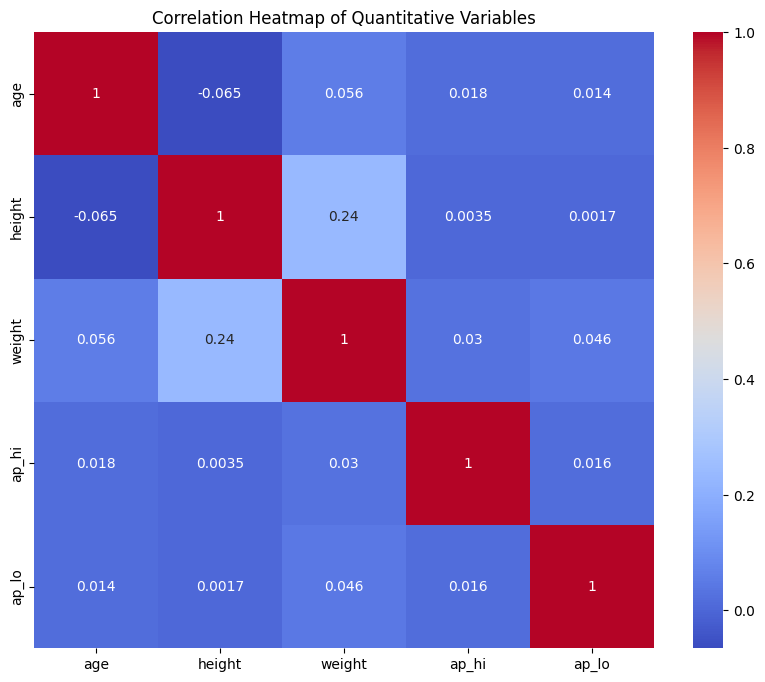

In [5]:
# Select quantitative variables
quantitative_vars = ['age', 'height', 'weight', 'ap_hi', 'ap_lo']

# Calculate the correlation matrix
corr_matrix = cardio[quantitative_vars].corr()

# Create a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Quantitative Variables')
plt.show()

This heat map visually describes the relationship between the quantitative variables in our study. None of the variables are strongly correlated.


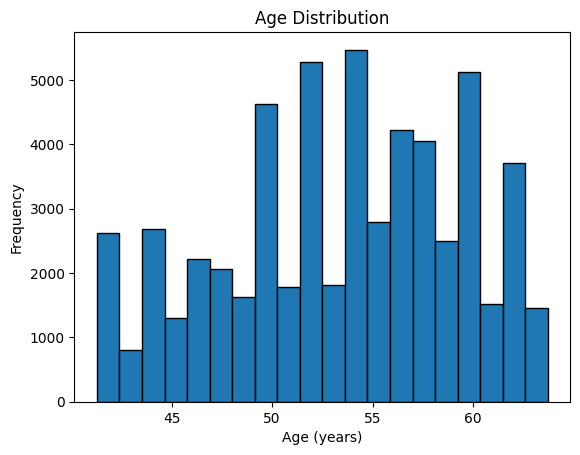

In [6]:
# Visualizing Age Distribution
plt.hist(cardio['age'], bins=20, edgecolor='k')
plt.xlabel('Age (years)')
plt.ylabel('Frequency')
plt.title('Age Distribution')
plt.show()

Age is normally distributed with a mean age is around 50.

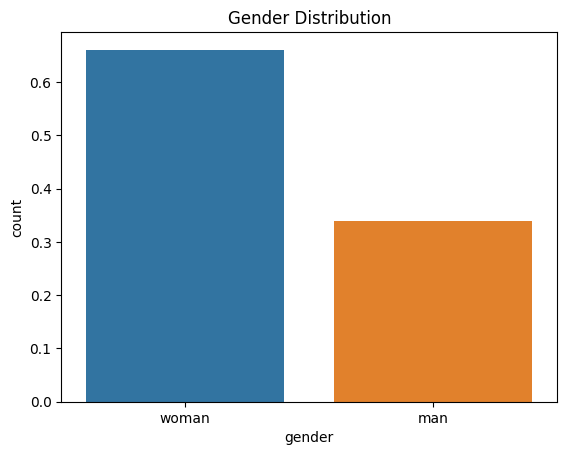

In [7]:
# Visualizing Gender Distribution
gender_counts = cardio['gender'].value_counts() / cardio['gender'].value_counts().sum()
sns.barplot(x=gender_counts.index, y=gender_counts)
plt.title('Gender Distribution')
plt.show()

There’s a higher proportion of women present in the dataset than men.


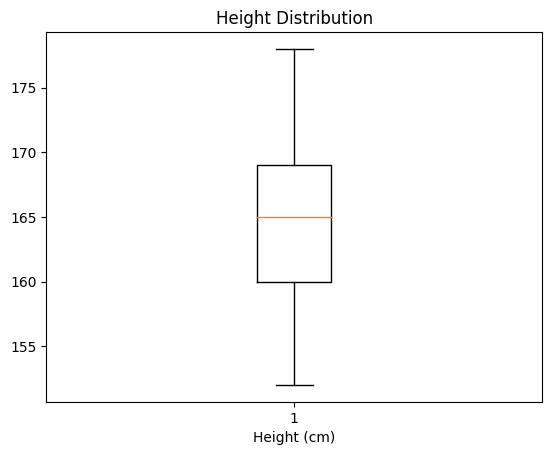

In [8]:
# Visualizing Height Distribution
plt.boxplot(cardio['height'])
plt.xlabel('Height (cm)')
plt.title('Height Distribution')
plt.show()

The median height of the data set is around 165 cm.

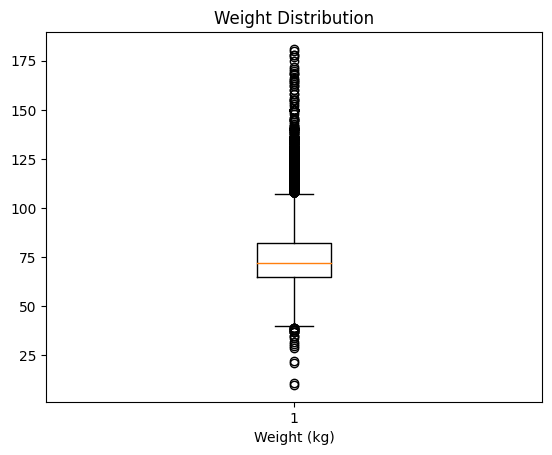

In [9]:
# Visualizing Weight Distribution
plt.boxplot(cardio['weight'])
plt.xlabel('Weight (kg)')
plt.title('Weight Distribution')
plt.show()

The median weight distribution is 72 kg.

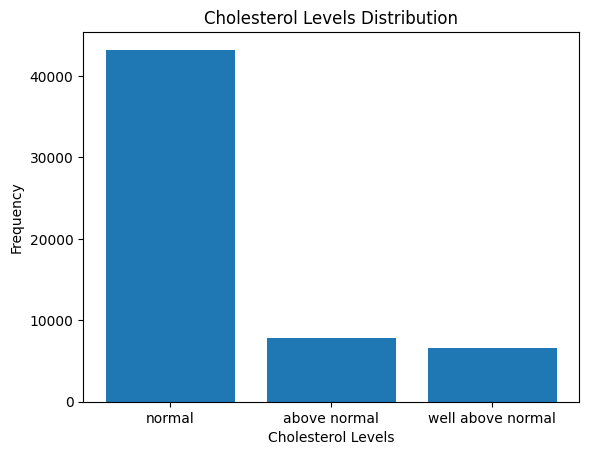

In [10]:
# Visualizing Cholesterol Levels
cholesterol_counts = cardio['cholesterol'].value_counts()
plt.bar(cholesterol_counts.index, cholesterol_counts)
plt.xlabel('Cholesterol Levels')
plt.ylabel('Frequency')
plt.title('Cholesterol Levels Distribution')
plt.show()

The majority of the patients sampled in our data set have normal cholesterol levels.

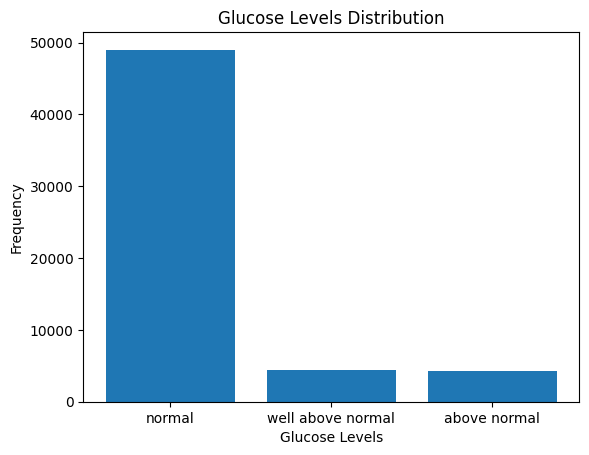

In [11]:
# Visualizing Glucose Levels
glucose_counts = cardio['gluc'].value_counts()
plt.bar(glucose_counts.index, glucose_counts)
plt.xlabel('Glucose Levels')
plt.ylabel('Frequency')
plt.title('Glucose Levels Distribution')
plt.show()

The majority of the patients sampled in our data set have normal glucose levels.

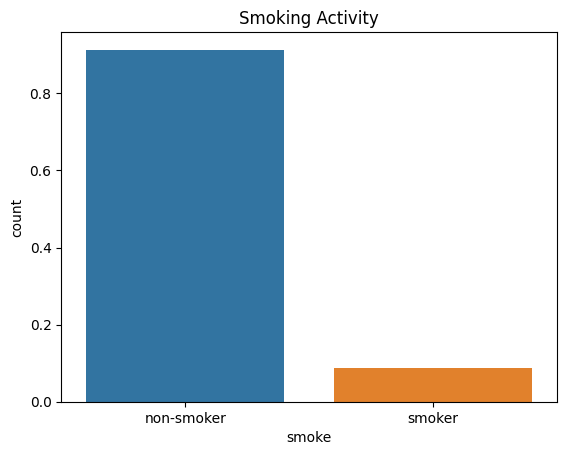

In [12]:
# Visualizing Smoking Activity
smoke_counts = cardio['smoke'].value_counts() / cardio['smoke'].value_counts().sum()
sns.barplot(x=smoke_counts.index, y=smoke_counts)
plt.title('Smoking Activity')
plt.show()

The majority of the patients sampled in our data set do not smoke.

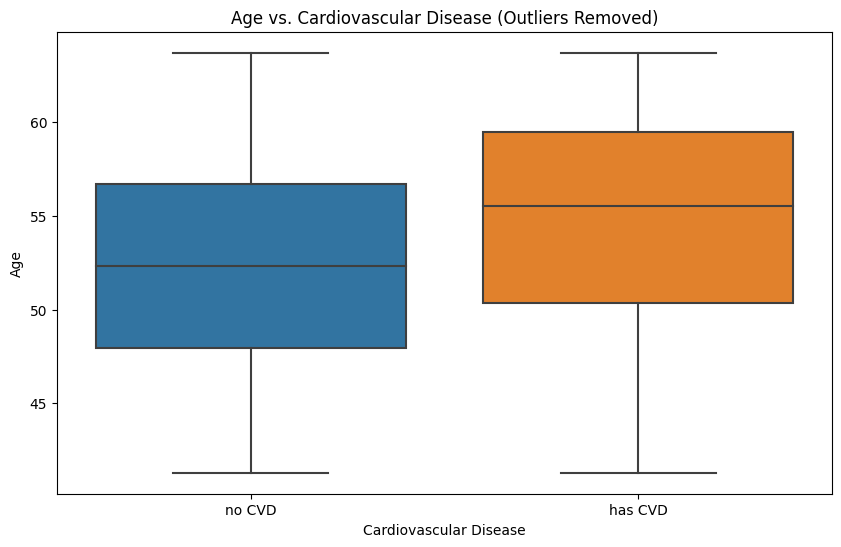

In [13]:
# Create box plots for age vs. cardiovascular disease
plt.figure(figsize=(10, 6))
sns.boxplot(data=cardio, x='cardio', y='age')
plt.xlabel('Cardiovascular Disease')
plt.ylabel('Age')
plt.title('Age vs. Cardiovascular Disease (Outliers Removed)')
plt.show()

People of higher ages have a higher tendency to have CVD. The median, Q1, and Q3 for age are all higher for those with CVD than those without CVD. 

Text(0.5, 1.0, 'BMI vs. Cardiovascular Disease (Outliers Removed)')

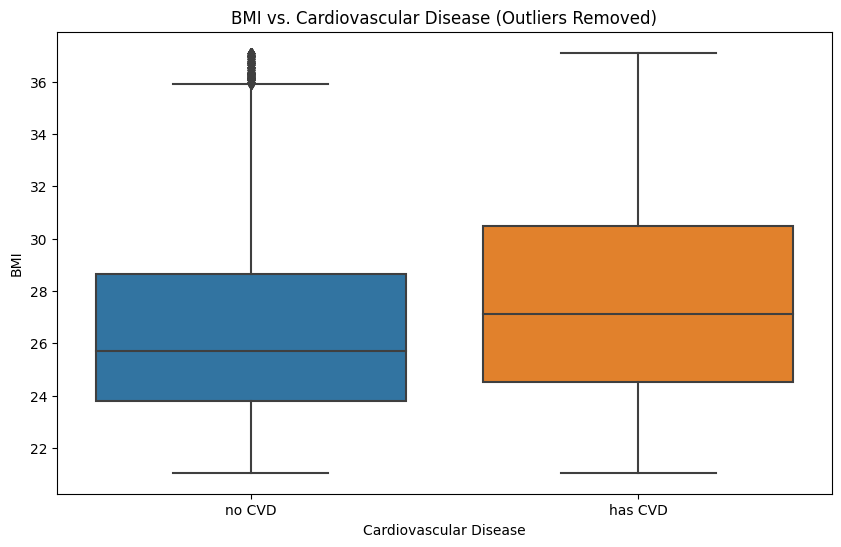

In [14]:
# Calculate BMI (Body Mass Index)
cardio['bmi'] = cardio['weight'] / ((cardio['height'] / 100) ** 2)

# Filter out outliers in BMI
cardio_filtered = cardio[(cardio['bmi'] >= cardio['bmi'].quantile(0.05)) & (cardio['bmi'] <= cardio['bmi'].quantile(0.95))]

# Add filtered BMI to cardio2
cardio2['bmi'] = cardio_filtered['bmi']

# Remove rows with NaN values in cardio2
cardio2 = cardio2.dropna()

# Reorder the columns
cols = list(cardio2.columns)
cols.remove('bmi')
cols.insert(-1, 'bmi')
cardio2 = cardio2[cols]

# Create a box plot for BMI vs. cardiovascular disease
plt.figure(figsize=(10, 6))
sns.boxplot(data=cardio_filtered, x='cardio', y='bmi')
plt.xlabel('Cardiovascular Disease')
plt.ylabel('BMI')
plt.title('BMI vs. Cardiovascular Disease (Outliers Removed)')

We observe that people with higher BMIs indicate a higher tendency to have cardiovascular disease. The median, Q1, and Q3 for BMI are higher for those with cardiovascular disease than those without cardiovascular disease.

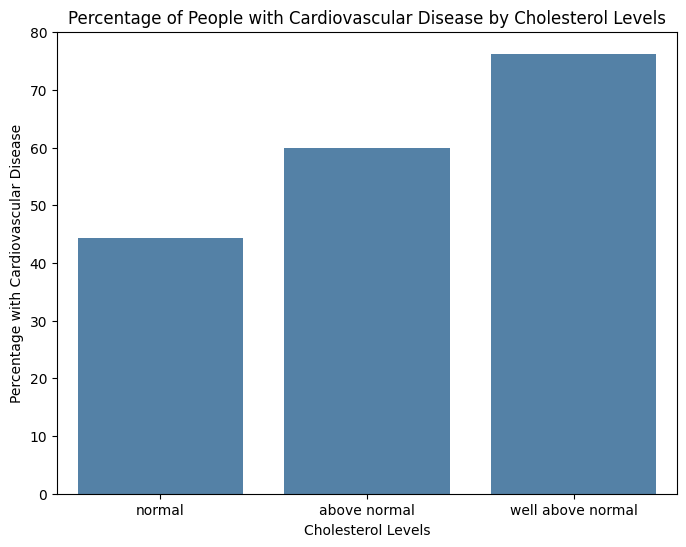

In [15]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage =cardio.groupby(['cholesterol', 'cardio']).size().unstack() /cardio.groupby('cholesterol').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='cholesterol', y='has CVD', color='steelblue',
            order=['normal', 'above normal', 'well above normal'])  # Specify the desired order of the bars
plt.xlabel('Cholesterol Levels')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Cholesterol Levels')

plt.show()


Sampled patients who have higher cholesterol levels have a higher likelihood of having cardiovascular disease.

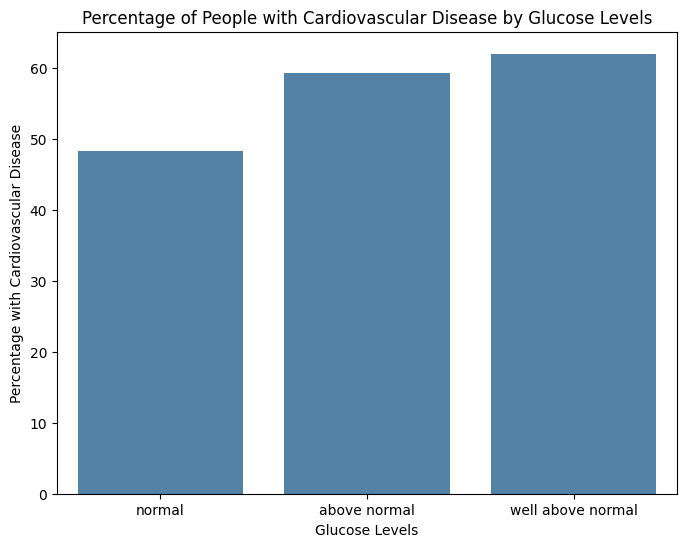

In [16]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage = cardio.groupby(['gluc', 'cardio']).size().unstack() /cardio.groupby('gluc').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='gluc', y='has CVD', color='steelblue',
            order=['normal', 'above normal', 'well above normal'])  # Specify the desired order of the bars
plt.xlabel('Glucose Levels')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Glucose Levels')

plt.show()

Sampled patients who have higher glucose levels have a higher likelihood of having cardiovascular disease.

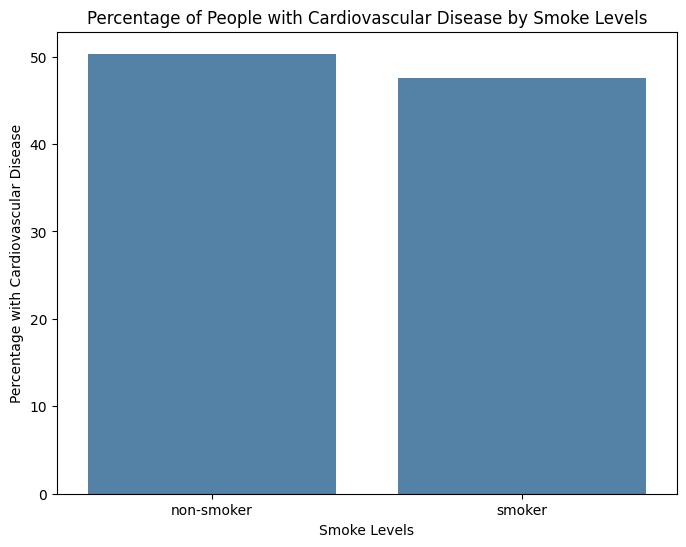

In [17]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage = cardio.groupby(['smoke', 'cardio']).size().unstack() / cardio.groupby('smoke').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='smoke', y='has CVD', color='steelblue')
plt.xlabel('Smoke Levels')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Smoke Levels')
plt.show()

We observe that there is little difference between the percentage of those who smoke and those who don’t and whether they have cardiovascular disease. 

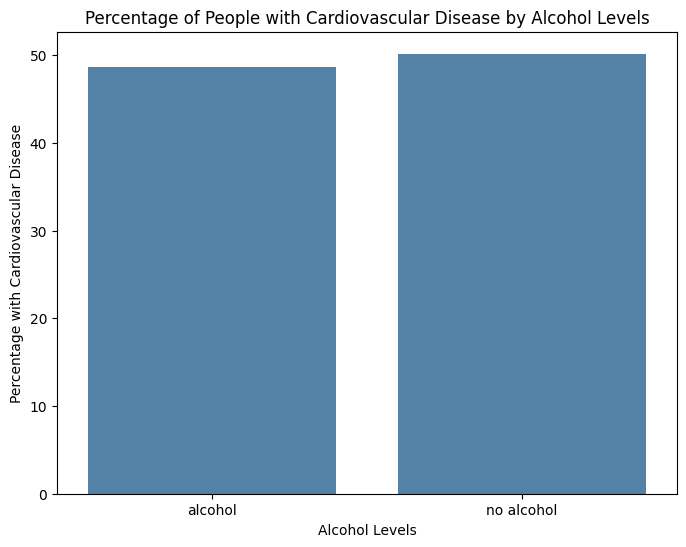

In [18]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage = cardio.groupby(['alco', 'cardio']).size().unstack() / cardio.groupby('alco').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='alco', y='has CVD', color='steelblue')
plt.xlabel('Alcohol Levels')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Alcohol Levels')


plt.show()

We observe that there is little difference between the percentage of those who intake alcohol and those who don’t and whether they have cardiovascular disease. 

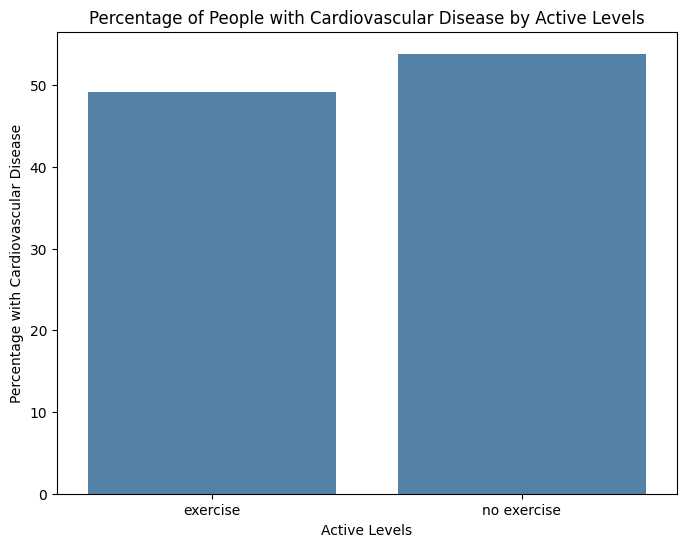

In [19]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage = cardio.groupby(['active', 'cardio']).size().unstack() / cardio.groupby('active').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='active', y='has CVD', color='steelblue')
plt.xlabel('Active Levels')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Active Levels')
plt.show()

We observe that those who are active are less likely to develop/be diagnosed with cardiovascular disease (CVD). 

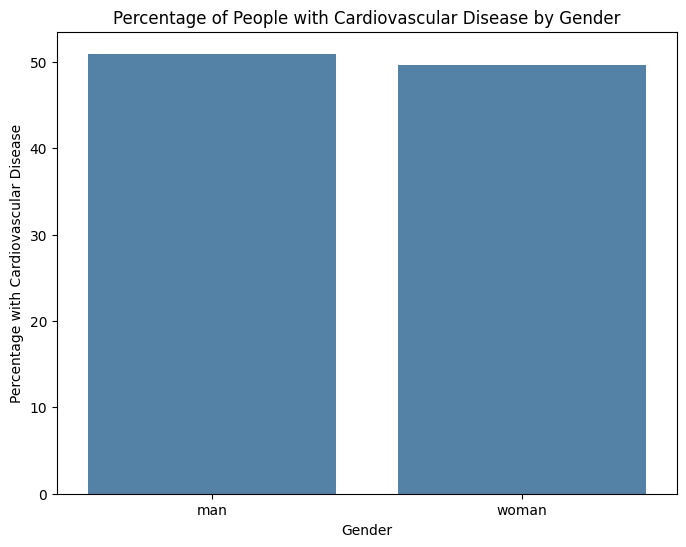

In [20]:
# Calculate the percentage of people at each cholesterol level with cardiovascular disease
percentage = cardio.groupby(['gender', 'cardio']).size().unstack() / cardio.groupby('gender').size().values[:, None]
percentage *= 100

# Create a bar plot showing the percentage of people with cardiovascular disease at each cholesterol level
plt.figure(figsize=(8, 6))
sns.barplot(data=percentage.reset_index(), x='gender', y='has CVD', color='steelblue')
plt.xlabel('Gender')
plt.ylabel('Percentage with Cardiovascular Disease')
plt.title('Percentage of People with Cardiovascular Disease by Gender')
plt.show()

We observe that there is little difference between the percentage of male and females sampled and whether they have cardiovascular disease. 

# Data Analysis & Results

In [21]:
# Transforming columns
numeric_cols = ['age', 'height', 'weight', 'ap_hi', 'ap_lo', 'bmi']
cat_cols = ['gender', 'cholesterol', 'gluc', 'smoke', 'alco', 'active']
preproc = ColumnTransformer(
    transformers = [
        ('standard_scaler', StandardScaler(), numeric_cols),
        ('categorical_cols', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ]
)

# Getting feature and response columns
dataset = cardio2[numeric_cols + cat_cols]
result = cardio2['cardio']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(dataset,
                                                   result,
                                                   test_size=0.2,
                                                   random_state=1)

In [22]:
# Decision Tree
# Making pipeline and fitting it on training set
pl_dt = Pipeline([
    ('preprocessor', preproc),
    ('dt', DecisionTreeClassifier(max_depth=5)),
])
pl_dt.fit(X_train, y_train)

# Getting the accuracy of the training and testing set
training_prediction_dt = pl_dt.predict(X_train)
testing_prediction_dt = pl_dt.predict(X_test)
training_accuracy_dt = metrics.accuracy_score(training_prediction_dt, y_train)
testing_accuracy_dt = metrics.accuracy_score(testing_prediction_dt, y_test)
print(f'Training accuracy: {training_accuracy_dt}')
print(f'Testing accuracy: {testing_accuracy_dt}')

Training accuracy: 0.7247304582210242
Testing accuracy: 0.7266076241817482


The decision tree model achieved a testing accuracy of 72.35%. This model works by recursively partitioning the dataset based on feature thresholds, creating a hierarchical structure of if-else decision rules. It selects the most informative features at each step to maximize the separation between classes, allowing for interpretable and understandable decision-making in the prediction of heart diseases.

In [23]:
# Logistic Regression
# Making pipeline and fitting it on training set
pl_lr = Pipeline([
    ('preprocessor', preproc),
    ('lr', LogisticRegression()),
])
pl_lr.fit(X_train, y_train)

# Getting the accuracy of the training and testing set
training_prediction_lr = pl_lr.predict(X_train)
testing_prediction_lr = pl_lr.predict(X_test)
training_accuracy_lr = metrics.accuracy_score(training_prediction_lr, y_train)
testing_accuracy_lr = metrics.accuracy_score(testing_prediction_lr, y_test)
print(f'Training accuracy: {training_accuracy_lr}')
print(f'Testing accuracy: {testing_accuracy_lr}')

Training accuracy: 0.7136359260685406
Testing accuracy: 0.7180400462071621


The logistic regression model achieved a testing accuracy of 71.20%. A logistic regression model is employed to predict the likelihood of CVD based on given features. By using a mathematical function to transform the input features into a probability score, the model enables straightforward classification and interpretation of the probability of an individual having CVD.

In [24]:
# Support Vector Machine (SVM)
# Making pipeline and fitting it on training set
pl_svm = Pipeline([
    ('preprocessor', preproc),
    ('svm', svm.SVC()),
])
pl_svm.fit(X_train, y_train)

# Getting the accuracy of the training and testing set
training_prediction_svm = pl_svm.predict(X_train)
testing_prediction_svm = pl_svm.predict(X_test)
training_accuracy_svm = metrics.accuracy_score(training_prediction_svm, y_train)
testing_accuracy_svm = metrics.accuracy_score(testing_prediction_svm, y_test)
print(f'Training accuracy: {training_accuracy_svm}')
print(f'Testing accuracy: {testing_accuracy_svm}')

Training accuracy: 0.7233827493261455
Testing accuracy: 0.7242972660762418


The support vector machine model achieved a testing accuracy of 71.42%. An SVM is a type of computer program that can sort different types of information into groups. It does this by drawing a line or boundary between the groups in a way that maximizes the separation between them. This program works by transforming the information into a different form and identifying the closest examples to the boundary, which help determine how to classify new data.

In [25]:
# Gaussian Naive Bayes
# Making pipeline and fitting it on training set
pl_nb = Pipeline([
    ('preprocessor', preproc),
    ('nb', GaussianNB()),
])
pl_nb.fit(X_train, y_train)

# Getting the accuracy of the training and testing set
training_prediction_nb = pl_nb.predict(X_train)
testing_prediction_nb = pl_nb.predict(X_test)
training_accuracy_nb = metrics.accuracy_score(training_prediction_nb, y_train)
testing_accuracy_nb = metrics.accuracy_score(testing_prediction_nb, y_test)
print(f'Training accuracy: {training_accuracy_nb}')
print(f'Testing accuracy: {testing_accuracy_nb}')

Training accuracy: 0.5925587216018483
Testing accuracy: 0.5958798613785137


The Gaussian Naive Bayes model achieved a testing accuracy fo 58.69%. It uses an algorithm that classifies classifies data based on the assumption that features follow a Gaussian (normal) distribution. It calculates the probability of a data point belonging to a specific class by combining the probabilities of its individual features using Bayes' theorem, ultimately selecting the class with the highest probability.

In [26]:
# XGBoost
# Making pipeline and fitting it on training set
pl_xg = Pipeline([
    ('preprocessor', preproc),
    ('xg', xgb.XGBClassifier()),
])
pl_xg.fit(X_train, y_train)

# Getting the accuracy of the training and testing set
training_prediction_xg = pl_xg.predict(X_train)
testing_prediction_xg = pl_xg.predict(X_test)
training_accuracy_xg = metrics.accuracy_score(training_prediction_xg, y_train)
testing_accuracy_xg = metrics.accuracy_score(testing_prediction_xg, y_test)
print(f'Training accuracy: {training_accuracy_xg}')
print(f'Testing accuracy: {testing_accuracy_xg}')

Training accuracy: 0.7698546399691952
Testing accuracy: 0.7234308817866769


The XGBoost model achieved a testing accuracy of 72.36%. XGBoost is a powerful machine learning algorithm that utilizes an ensemble of decision trees to make predictions. It works by iteratively building decision trees, where each subsequent tree is trained to correct the mistakes made by the previous trees. XGBoost optimizes a specific objective function, taking into account both the accuracy of predictions and the complexity of the model, to create a strong ensemble that can handle complex relationships and provide accurate predictions.

In [27]:
# Random Forest
# Making pipeline and fitting it on training set
pl_rf = Pipeline([
    ('preprocessor', preproc),
    ('rf', RandomForestClassifier()),
])
pl_rf.fit(X_train, y_train)

# Getting the accuracy of the training and testing set
training_prediction_rf = pl_rf.predict(X_train)
testing_prediction_rf = pl_rf.predict(X_test)
training_accuracy_rf = metrics.accuracy_score(training_prediction_rf, y_train)
testing_accuracy_rf = metrics.accuracy_score(testing_prediction_rf, y_test)
print(f'Training accuracy: {training_accuracy_rf}')
print(f'Testing accuracy: {testing_accuracy_rf}')

Training accuracy: 0.9998315363881402
Testing accuracy: 0.698016942626107


The random forest model achieved a testing accuracy of about 69%. This is a machine learning model that combines multiple decision trees to make predictions. It works by constructing a set of decision trees, where each tree is trained on a random subset of the training data and features. The final prediction is obtained by aggregating the predictions of all the individual trees, resulting in a robust and accurate model that can handle complex data relationships and provide reliable predictions.

In [28]:
# Artificial Neural Network
# Making pipeline and fitting it on training set
pl_nn = Pipeline([
    ('preprocessor', preproc),
    ('nn', MLPClassifier()),
])
pl_nn.fit(X_train, y_train)

# Getting the accuracy of the training and testing set
training_prediction_nn = pl_nn.predict(X_train)
testing_prediction_nn = pl_nn.predict(X_test)
training_accuracy_nn = metrics.accuracy_score(training_prediction_nn, y_train)
testing_accuracy_nn = metrics.accuracy_score(testing_prediction_nn, y_test)
print(f'Training accuracy: {training_accuracy_nn}')
print(f'Testing accuracy: {testing_accuracy_nn}')

Training accuracy: 0.7286051212938005
Testing accuracy: 0.7241047362341163


The artificial neural network model achieved a testing accuracy of about 72%. An artificial neural network (ANN) is a machine learning model that mimics the structure and function of the human brain. It learns by adjusting the connections between nodes, or neurons, based on input data to improve its ability to make predictions or classifications.

Accuracy Score: 0.7266076241817482
Precision Score: 0.7807486631016043
Recall Score: 0.6236893203883496
F1 Score: 0.6934369602763386


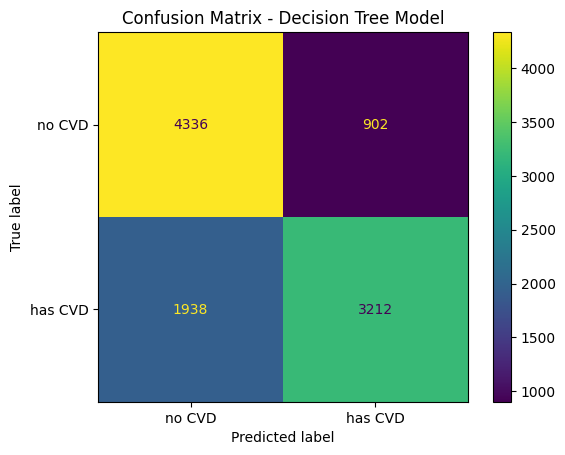

In [29]:
# Confusion Matrix for Decision Tree Model
display_labels = ['no CVD', 'has CVD']
dt_confusion_matrix = ConfusionMatrixDisplay.from_estimator(pl_dt, X_test, y_test, display_labels=display_labels)

dt_accuracy = accuracy_score(y_test, testing_prediction_dt)
dt_precision = precision_score(y_test, testing_prediction_dt, pos_label=1)
dt_recall = recall_score(y_test, testing_prediction_dt, pos_label=1)
dt_f1 = f1_score(y_test, testing_prediction_dt, pos_label=1)
dt_confusion_matrix.ax_.set_title('Confusion Matrix - Decision Tree Model')

print(f'Accuracy Score: {dt_accuracy}')
print(f'Precision Score: {dt_precision}')
print(f'Recall Score: {dt_recall}')
print(f'F1 Score: {dt_f1}')

dt_confusion_matrix

Accuracy Score: 0.7180400462071621
Precision Score: 0.7399006264852019
Recall Score: 0.6650485436893204
F1 Score: 0.7004806217404643


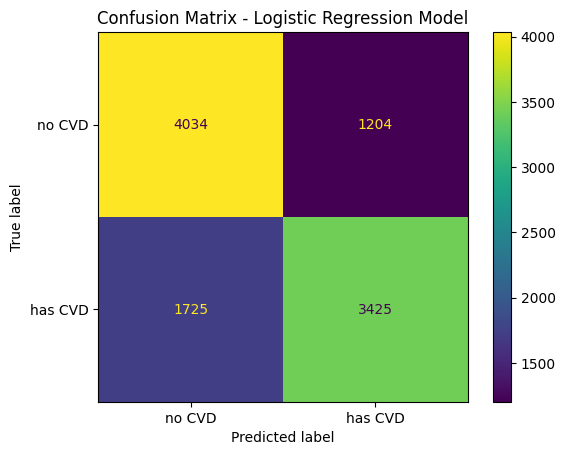

In [30]:
# Confusion matrix for Logistic Regression Model
display_labels = ['no CVD', 'has CVD']
lr_confusion_matrix = ConfusionMatrixDisplay.from_estimator(pl_lr, X_test, y_test, display_labels=display_labels)

lr_accuracy = accuracy_score(y_test, testing_prediction_lr)
lr_precision = precision_score(y_test, testing_prediction_lr, pos_label=1)
lr_recall = recall_score(y_test, testing_prediction_lr, pos_label=1)
lr_f1 = f1_score(y_test, testing_prediction_lr, pos_label=1)
lr_confusion_matrix.ax_.set_title('Confusion Matrix - Logistic Regression Model')

print(f'Accuracy Score: {lr_accuracy}')
print(f'Precision Score: {lr_precision}')
print(f'Recall Score: {lr_recall}')
print(f'F1 Score: {lr_f1}')

lr_confusion_matrix

Accuracy Score: 0.7242972660762418
Precision Score: 0.7431914893617021
Recall Score: 0.678252427184466
F1 Score: 0.7092385786802029


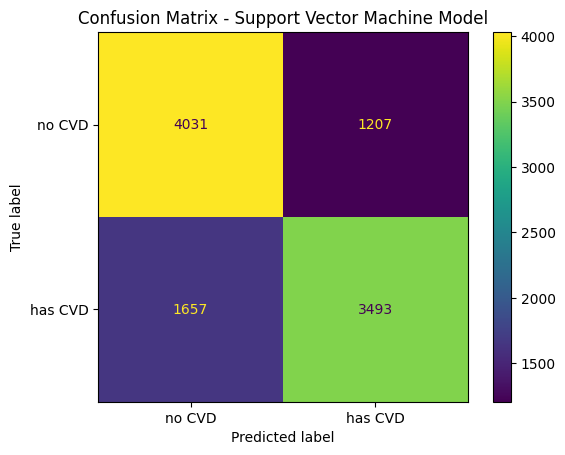

In [31]:
# Confusion matrix for Support Vector Machine Model
display_labels = ['no CVD', 'has CVD']
svm_confusion_matrix = ConfusionMatrixDisplay.from_estimator(pl_svm, X_test, y_test, display_labels=display_labels)

svm_accuracy = accuracy_score(y_test, testing_prediction_svm)
svm_precision = precision_score(y_test, testing_prediction_svm, pos_label=1)
svm_recall = recall_score(y_test, testing_prediction_svm, pos_label=1)
svm_f1 = f1_score(y_test, testing_prediction_svm, pos_label=1)
svm_confusion_matrix.ax_.set_title('Confusion Matrix - Support Vector Machine Model')

print(f'Accuracy Score: {svm_accuracy}')
print(f'Precision Score: {svm_precision}')
print(f'Recall Score: {svm_recall}')
print(f'F1 Score: {svm_f1}')

svm_confusion_matrix

Accuracy Score: 0.5958798613785137
Precision Score: 0.6656228253305497
Recall Score: 0.37145631067961166
F1 Score: 0.4768195413758724


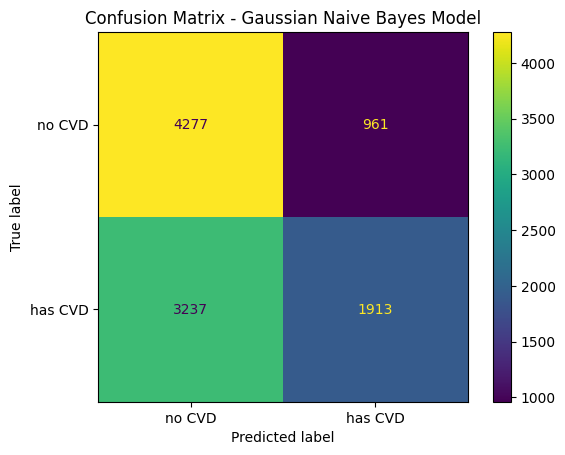

In [32]:
# Confusion matrix for Gaussian Naive Bayes Model
display_labels = ['no CVD', 'has CVD']
nb_confusion_matrix = ConfusionMatrixDisplay.from_estimator(pl_nb, X_test, y_test, display_labels=display_labels)

nb_accuracy = accuracy_score(y_test, testing_prediction_nb)
nb_precision = precision_score(y_test, testing_prediction_nb, pos_label=1)
nb_recall = recall_score(y_test, testing_prediction_nb, pos_label=1)
nb_f1 = f1_score(y_test, testing_prediction_nb, pos_label=1)
nb_confusion_matrix.ax_.set_title('Confusion Matrix - Gaussian Naive Bayes Model')

print(f'Accuracy Score: {nb_accuracy}')
print(f'Precision Score: {nb_precision}')
print(f'Recall Score: {nb_recall}')
print(f'F1 Score: {nb_f1}')

nb_confusion_matrix

Accuracy Score: 0.7234308817866769
Precision Score: 0.7466955579631636
Recall Score: 0.669126213592233
F1 Score: 0.7057859703020992


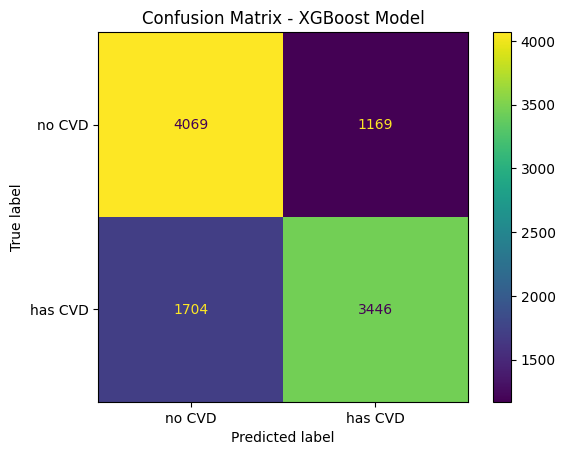

In [33]:
# Confusion matrix for XGBoost Model
display_labels = ['no CVD', 'has CVD']
xg_confusion_matrix = ConfusionMatrixDisplay.from_estimator(pl_xg, X_test, y_test, display_labels=display_labels)

xg_accuracy = accuracy_score(y_test, testing_prediction_xg)
xg_precision = precision_score(y_test, testing_prediction_xg, pos_label=1)
xg_recall = recall_score(y_test, testing_prediction_xg, pos_label=1)
xg_f1 = f1_score(y_test, testing_prediction_xg, pos_label=1)
xg_confusion_matrix.ax_.set_title('Confusion Matrix - XGBoost Model')

print(f'Accuracy Score: {xg_accuracy}')
print(f'Precision Score: {xg_precision}')
print(f'Recall Score: {xg_recall}')
print(f'F1 Score: {xg_f1}')

xg_confusion_matrix

Accuracy Score: 0.698016942626107
Precision Score: 0.6991097922848665
Recall Score: 0.6862135922330097
F1 Score: 0.6926016658500734


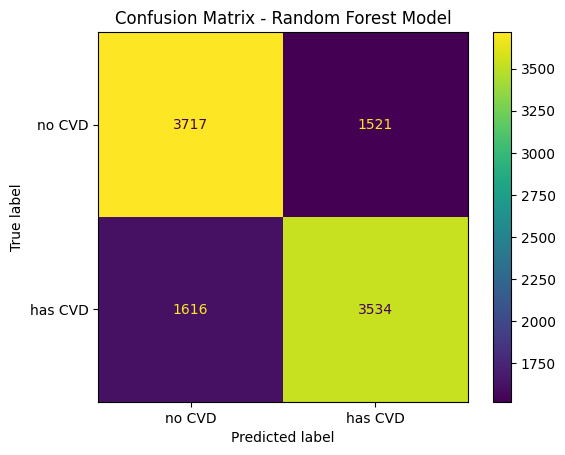

In [34]:
# Confusion matrix for Random Forest Model
display_labels = ['no CVD', 'has CVD']
rf_confusion_matrix = ConfusionMatrixDisplay.from_estimator(pl_rf, X_test, y_test, display_labels=display_labels)

rf_accuracy = accuracy_score(y_test, testing_prediction_rf)
rf_precision = precision_score(y_test, testing_prediction_rf, pos_label=1)
rf_recall = recall_score(y_test, testing_prediction_rf, pos_label=1)
rf_f1 = f1_score(y_test, testing_prediction_rf, pos_label=1)
rf_confusion_matrix.ax_.set_title('Confusion Matrix - Random Forest Model')

print(f'Accuracy Score: {rf_accuracy}')
print(f'Precision Score: {rf_precision}')
print(f'Recall Score: {rf_recall}')
print(f'F1 Score: {rf_f1}')

rf_confusion_matrix

Accuracy Score: 0.7241047362341163
Precision Score: 0.7381150959132611
Recall Score: 0.6873786407766991
F1 Score: 0.711843957369797


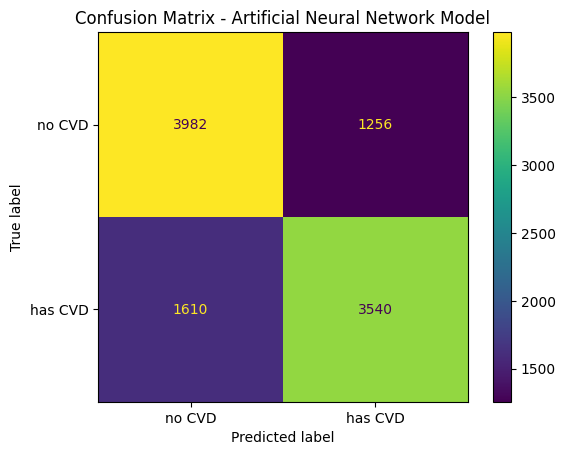

In [35]:
# Confusion matrix for Artificial Neural Network Model
display_labels = ['no CVD', 'has CVD']
nn_confusion_matrix = ConfusionMatrixDisplay.from_estimator(pl_nn, X_test, y_test, display_labels=display_labels)

nn_accuracy = accuracy_score(y_test, testing_prediction_nn)
nn_precision = precision_score(y_test, testing_prediction_nn, pos_label=1)
nn_recall = recall_score(y_test, testing_prediction_nn, pos_label=1)
nn_f1 = f1_score(y_test, testing_prediction_nn, pos_label=1)
nn_confusion_matrix.ax_.set_title('Confusion Matrix - Artificial Neural Network Model')

print(f'Accuracy Score: {nn_accuracy}')
print(f'Precision Score: {nn_precision}')
print(f'Recall Score: {nn_recall}')
print(f'F1 Score: {nn_f1}')

nn_confusion_matrix

We conducted an evaluation of various models commonly used for detecting heart disease, including the decision tree, logistic regression, support vector machine, Gaussian Naive Bayes, XGBoost, random forest, and artificial neural network models. Among these models, the decision tree, XGBoost, and artificial neural network yielded the highest accuracy. The XGBoost model consistently achieved the highest accuracy of 72.36%, slightly outperforming the decision tree model (72.35%). The artificial neural network, while exhibiting some randomness resulting in accuracy around 72%, tended to be below 72.3%.

However, it is worth noting that the artificial neural network model demonstrated the highest F1 score, indicating superior accuracy when considering both precision and recall scores, which account for false positives and false negatives. Despite a slight trade-off in accuracy compared to the other two models, the artificial neural network model has the highest F1 score (about 71.3%).

In the context of predicting CVD, prioritizing the F1 score is crucial due to the potential consequences of both false positives and false negatives. False positives occur when the model incorrectly identifies an individual as having the disease, leading to unnecessary medical interventions and psychological distress. False negatives, on the other hand, happen when the model fails to identify individuals with the disease, potentially delaying necessary treatments and increasing the risk of adverse health outcomes. By prioritizing the F1 score, which considers both precision and recall, we ensure a balanced evaluation of the model's performance.

Therefore, in predicting CVD, selecting the machine learning model with the highest accuracy and F1 score allows for accurate classification while considering the real-world implications and potential risks associated with both false positives and false negatives. The artificial neural network emerges as the most suitable machine learning model to utilize.

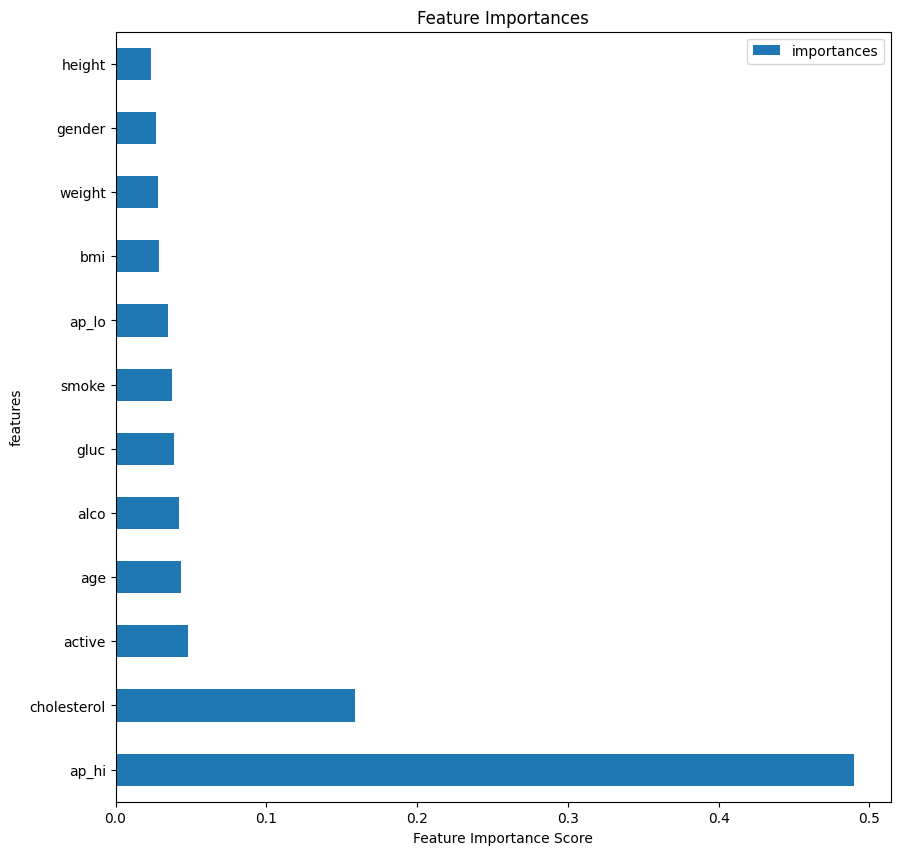

In [36]:
# Feature importances
ss = StandardScaler()
X_train[numeric_cols] = ss.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = ss.transform(X_test[numeric_cols])
my_model=xgb.XGBClassifier(n_estimators=100).fit(X_train,y_train)
feat_imp=pd.DataFrame({'importances':my_model.feature_importances_})
feat_imp['features']=X_train.columns
feat_imp=feat_imp.sort_values(by='importances',ascending=False)
feat_imp=feat_imp.set_index('features')
feat_imp.plot.barh(title='Feature Importances',figsize=(10,10))
plt.xlabel('Feature Importance Score')
plt.show()

XGBoost's feature importance algorithm calculates the importance of each feature in predicting the target variable (CVD). It retrieves scores for attributes in boosted decision trees, which organize data into a tree-like structure. Boosting combines weak learners (decision trees) iteratively to create a strong learner, correcting errors made by previous trees. The algorithm learns by fitting residuals from preceding trees. XGBoost's feature importance assesses how frequently features are used in important decisions within boosted trees. Crucial features for accurate predictions receive higher importance scores. These scores are explicitly calculated for each attribute, enabling ranking and comparison. According to the feature importance plot, ap_hi (systolic blood pressure) and cholesterol have the highest feature importance scores and the largest effect on predicting one's likelihood of having CVD.  

ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


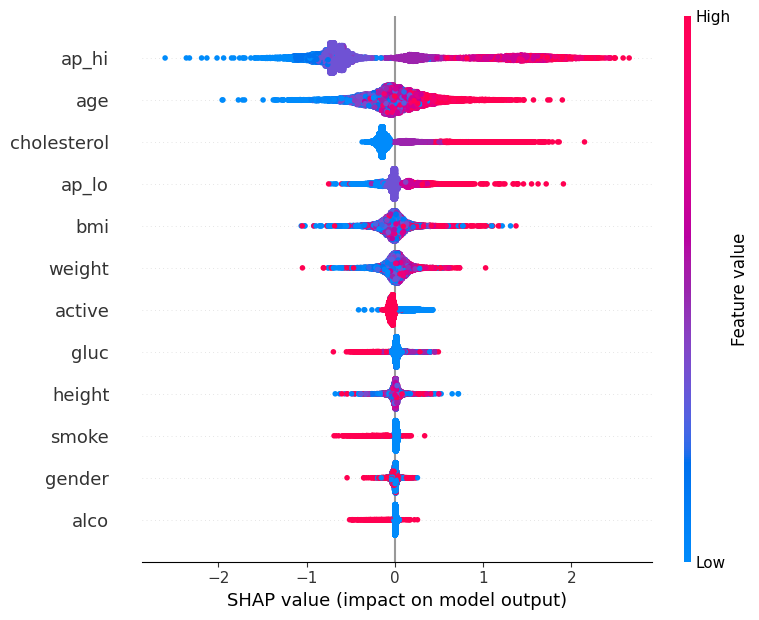

In [37]:
# SHAP plot
explainer=shap.TreeExplainer(my_model)
shap_values=explainer.shap_values(X_test)
shap.summary_plot(shap_values,X_test)

A SHAP plot visualizes the contribution of individual features to a machine learning model's predictions. It examines each feature's impact on the model output while taking into account their interactions with other features, providing insights into their relative importance.

The SHAP plot provides valuable insights into the relationship between various features and the prediction of CVD. Notably, as the feature values of systolic and diastolic blood pressure, cholesterol, weight, BMI, and age increase, their corresponding SHAP values also increase. This observation suggests that these factors play a significant role in determining the likelihood of developing CVD. Furthermore, the consistent alignment of these findings with existing studies further strengthens the reliability of the model and highlights the importance of monitoring and managing blood pressure as a major risk factor for CVD in the aging population.

# Ethics & Privacy

One of the ethical concerns revolves around the potential inaccuracies in the recording of measurements by individuals. The limitations in our dataset, stemming from these potential inaccuracies, may restrict the accuracy and holistic understanding of the factors involved. However, since we lack additional information, we must assume that our analysis is conducted ethically, taking into account the limitations of the data. Our questions are designed to focus on indisputable characteristics of the human body, combined with the statistical data available, in order to mitigate inherent human biases.

It is worth noting that human intervention during data collection may have introduced potential inaccuracies, although the large dataset helps to minimize such errors. Additionally, the data we utilized comes from a reliable and publicly accessible source, Kaggle, which implies that it was obtained legally and through scientific means. Although direct transparency regarding the data collection process is not explicitly stated, the professional setting of medical examinations and the involvement of medical professionals should alleviate concerns.
The credibility of the main data scientist, Svetlana Ulianova, who was responsible for collecting the dataset, adds to the reliability of the data. With a Master's degree from New York University and experience as a data scientist at reputable companies like Mastercard, her qualifications suggest unbiased and accurate data collection methods.

Given the gravity of CVD, it is crucial that our analysis be conducted methodically and without external bias, as we aim to develop a tool that can help predict its presence in a professional setting.

Moving forward, to mitigate bias and minimize user error, we can enhance data accuracy and ensure a more representative sample by restricting data entry to trained professionals proficient in accurate data recording.

# Conclusion & Discussion

Our initial hypothesis was confirmed as we observed the significant role of systolic blood pressure, which aligned with our expectations. Furthermore, our analysis emphasized the importance of diastolic blood pressure, cholesterol levels, age, weight, height, and BMI, as indicated by the SHAP plot.

To construct our predictive models, we evaluated several common algorithms, including decision trees, Gaussian Naive Bayes, and support vector machines. Among them, the decision tree, artificial neural network, and XGBoost models exhibited the highest accuracy. However, the artificial neural network outperformed the others when considering both false positives and false negatives.

It is important to acknowledge that our models have limitations and are not infallible. Nonetheless, they serve as a valuable foundation for further enhancements. To improve accuracy, we can explore additional binary classification algorithms and fine-tune their hyperparameters. Additionally, acquiring a larger and more diverse dataset would contribute to refining the model's performance.

The significance of this study lies in identifying crucial factors, such as systolic blood pressure, BMI, weight, age, and others, for predicting the presence of cardiovascular disease (CVD). This information empowers individuals to recognize potential risks associated with the extreme values of these factors. Moreover, we have successfully developed a reasonably accurate model for predicting the presence of CVD based on individual specifications.

Given the importance of CVD and the potential consequences of mispredictions, it is imperative to continue efforts to improve the model's accuracy, which currently stands at approximately 72%. Expanding the dataset and incorporating more comprehensive data should be pursued to further enhance the model's performance.

## Interface

**TO BE ADDED**